# Importing Libraries

In [46]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, log_loss, f1_score
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from hyperopt import hp, tpe, fmin, Trials, space_eval
import warnings
import shap
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
from Functions_George import read_txt_file

# Importing Data and clipping the "bad" looking ones

In [47]:
Data = pd.read_csv('features.csv')

path1, path2 = 'ctrl_dis.txt', 'pntr_dis.txt'
Control_dis, Drug_dis = read_txt_file(path1), read_txt_file(path2)

First_damaged = Data[Data['label'] == 1].index[0]

Indices_to_discard = Control_dis + [x + First_damaged for x in Drug_dis]
Data = Data.drop(Indices_to_discard, axis = 0)

###Check for NaN's###
if Data.isnull().any().any():
    raise ValueError("DataFrame contains at least one NaN value")

print('Got',len(Data),'entries')

Got 2040 entries


# Splitting the Data into train, validation and test sets
# and training a Classifier to determine the importances

In [48]:
X = Data.drop(['label'], axis=1)
y = Data['label']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split the data into training and validation sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.1,
                            max_depth=8, eval_metric='logloss', n_estimators=300,
                            seed=42, use_label_encoder=False, n_jobs = -1)

start_time = time.time()
xgb_clf.fit(X_train, y_train)
end_time = time.time()

elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds \n")

# Make predictions on the validation set and evaluation scores
y_pred_proba = xgb_clf.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val, y_pred_proba.round())
conf_matrix = confusion_matrix(y_val, y_pred_proba.round())
logloss = log_loss(y_val, y_pred_proba)

print('On the Validation set:\n')
print("Accuracy:", accuracy)
print("LogLoss:", logloss,)
print("Confusion matrix:", conf_matrix[0], "\n"," "*16, conf_matrix[1])


# Make predictions on the test set and evaluation scores
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred_proba.round())
conf_matrix = confusion_matrix(y_test, y_pred_proba.round())
logloss = log_loss(y_test, y_pred_proba)
print('On the Test set:\n')
print("Accuracy:", accuracy)
print("LogLoss:", logloss)
print("Confusion matrix:", conf_matrix[0], "\n"," "*16, conf_matrix[1])

Elapsed time: 0.8163430690765381 seconds 

On the Validation set:

Accuracy: 0.8315217391304348
LogLoss: 0.504862979977598
Confusion matrix: [77 10] 
                  [21 76]
On the Test set:

Accuracy: 0.8333333333333334
LogLoss: 0.4304393636122349
Confusion matrix: [89 15] 
                  [19 81]


# 20 most important features using XGBoost's feature importance

In [49]:
importances = xgb_clf.feature_importances_
sorted_indices = importances.argsort()[::-1]
top_features = X.columns[sorted_indices[:20]]

top_features_df = pd.DataFrame({'Top Features based on feature importances': top_features}, index=range(1, len(top_features) + 1))
display(top_features_df)

,Top Features based on feature importances
1,getEdgeFluxR
2,getAreaOfHoles
3,getH8R
4,getNucleusMinR
5,getEntropyR
6,getCellStdR
7,getEntropyB
8,getH12B
9,getH5R
10,getH1R


# Correlation matrix of the most important features

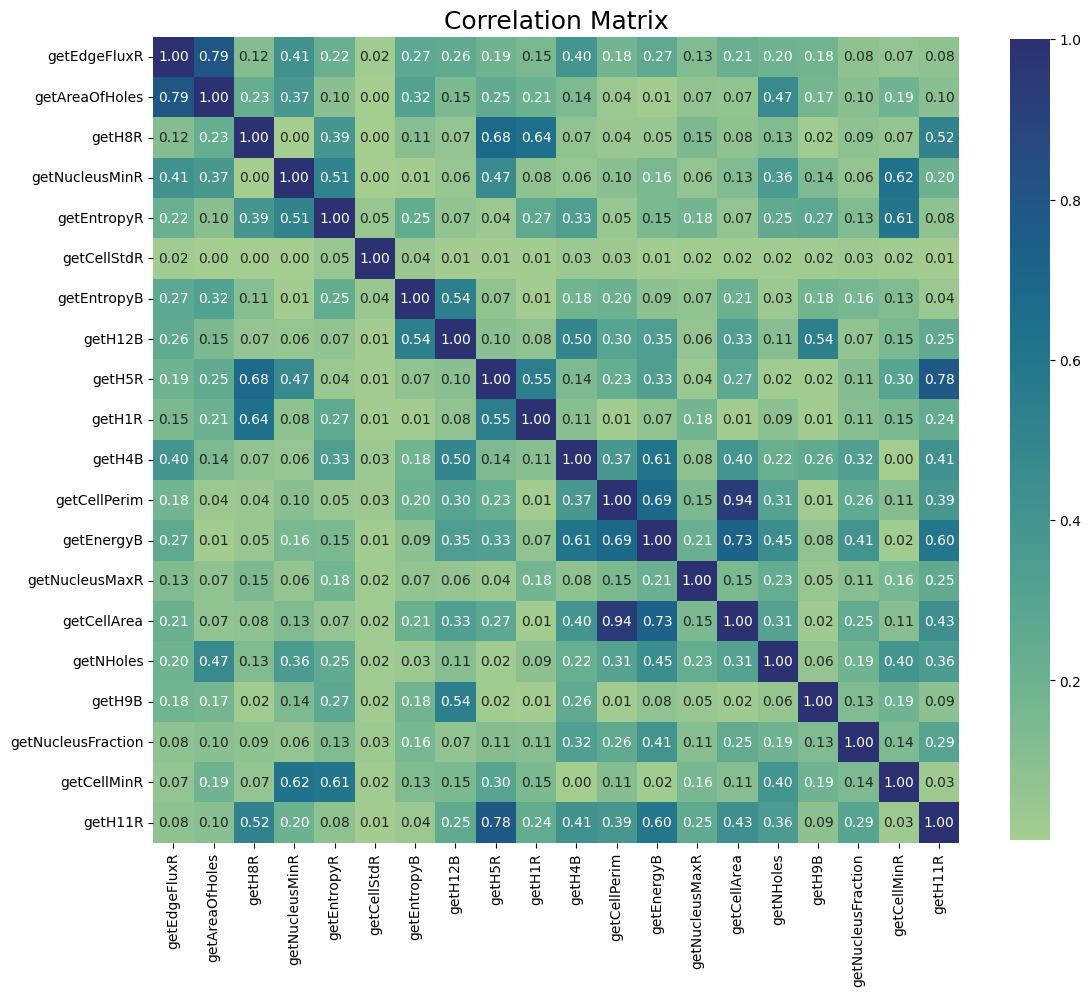

In [50]:
X_top_features = X[top_features]
correlation_matrix = X_top_features.corr()

###UNCOMMENT FOR SPEARMAN METHOD####
# correlation_matrix = X_top_features.corr(method = 'spearman')

fig, ax = plt.subplots(figsize = (13,13))
sns.heatmap(np.abs(correlation_matrix), annot = True, cmap = 'crest', square = True, fmt=".2f", cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix', fontsize = 18)
plt.show()

# 20 most important features using Shap values on all data

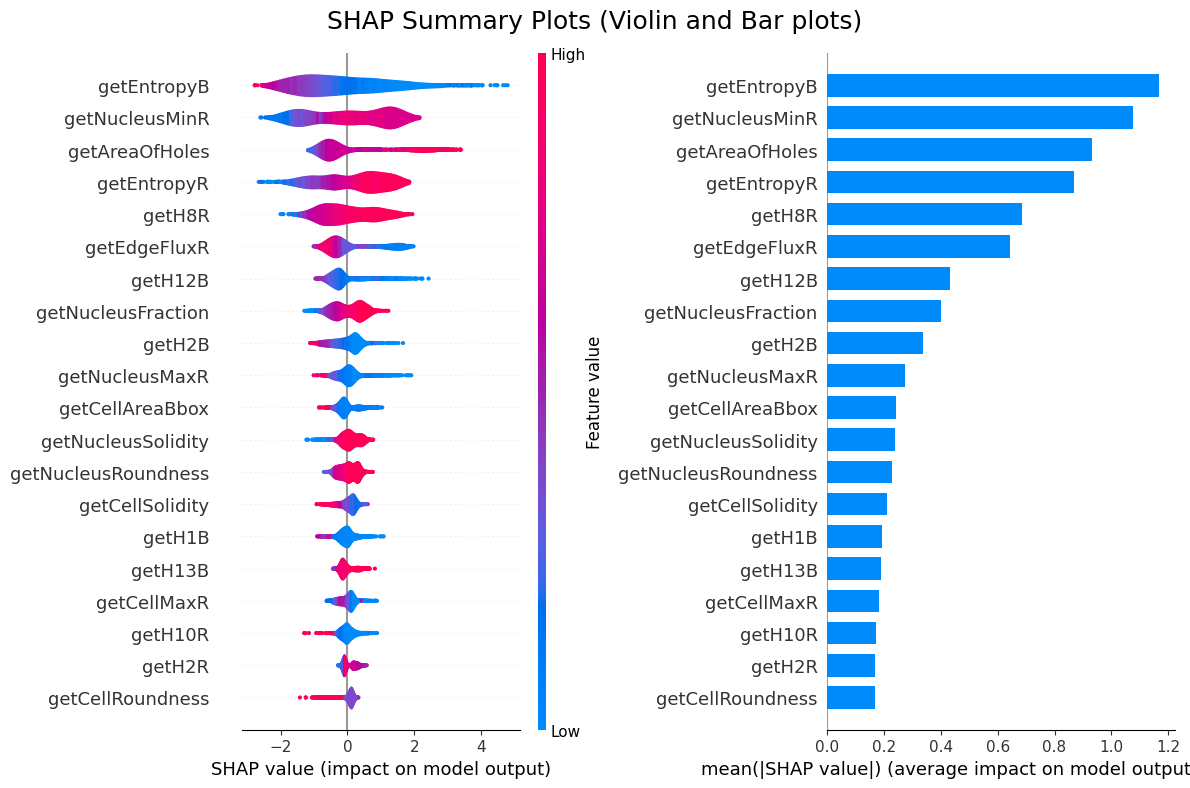

In [59]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_train)

fig, ax = plt.subplots(1, 2, figsize=(10, 8))

shap.summary_plot(shap_values, X, feature_names=X.columns, plot_type='bar', show = False, plot_size = (12, 8))
plt.sca(ax[0]) 

shap.summary_plot(shap_values, X, plot_type='violin', show = False, plot_size = (12, 8))
plt.sca(ax[1])
fig.suptitle('SHAP Summary Plots (Violin and Bar plots)', fontsize=18)
plt.tight_layout()
plt.show()

# Correlation matrix of the most important features (SHAP)

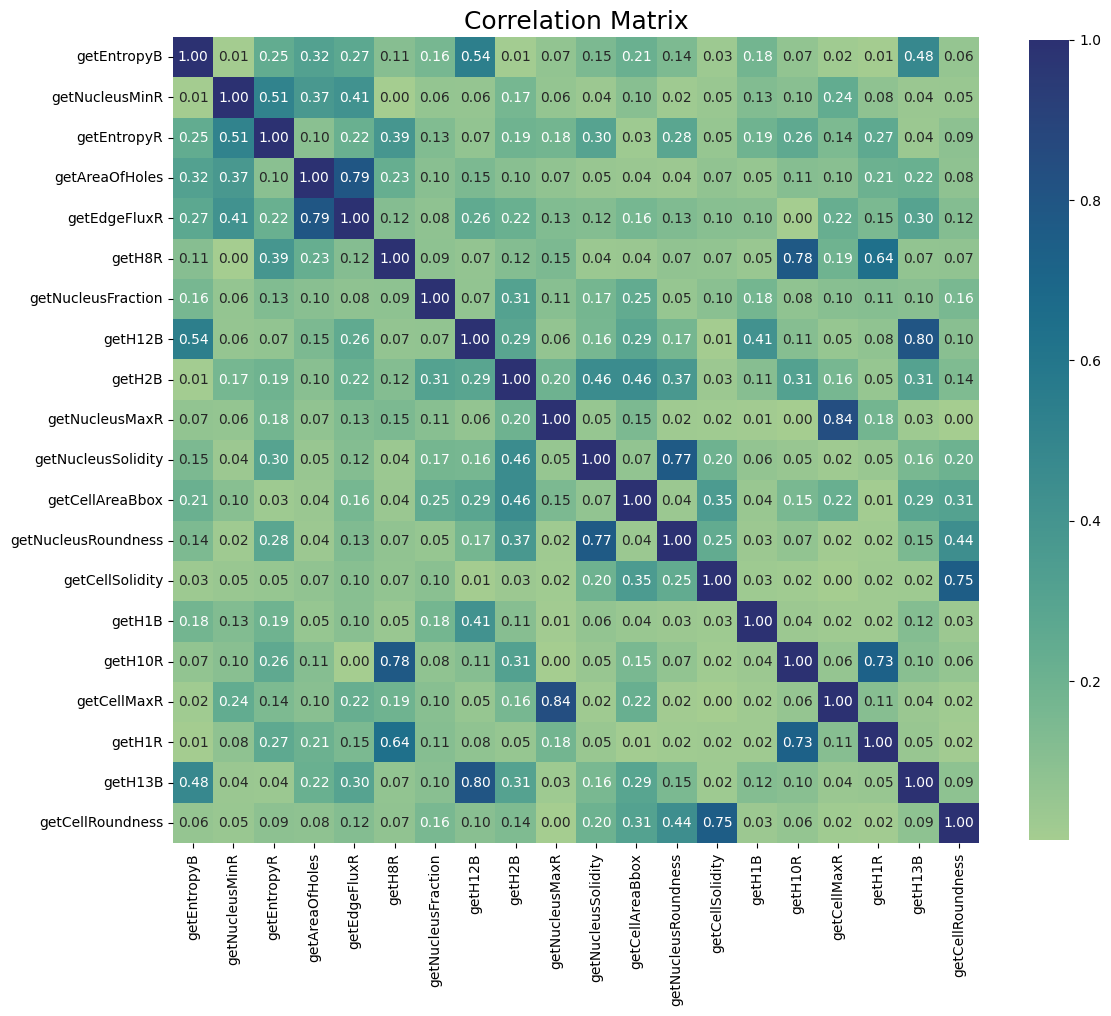

In [58]:
feature_importance = np.abs(shap_values).mean(axis=0)
top_indices_shap = np.argsort(feature_importance)[-20:][::-1]
top_features_shap = X.columns[top_indices_shap]

X_top_features_shap = X[top_features_shap]
correlation_matrix_shap = X_top_features_shap.corr()
###UNCOMMENT FOR SPEARMAN METHOD####
# correlation_matrix_shap = X_top_features_shap.corr(method = 'spearman')

fig, ax = plt.subplots(figsize = (13,13))
sns.heatmap(np.abs(correlation_matrix_shap), annot = True, cmap = 'crest', square = True, fmt=".2f", cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix', fontsize = 18)
plt.show()

# Hyperparameter search (Bayes optimization) with Cross-Validation

In [53]:
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-05), np.log(0.3)),
    'dropout': hp.loguniform('dropout', np.log(1e-08), np.log(0.5)),
    'max_depth': hp.choice('max_depth', np.arange(3, 20, dtype=int)),
    'subsample': hp.uniform('subsample', 0.0, 1), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.0, 1),
    'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1)),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 3000, 50, dtype=int)),
    'min_child_weight': hp.loguniform('min_child_weight', np.log(1e-8), np.log(10)),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-8), np.log(10)), 
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-8), np.log(10)),
    'scale_pos_weight': hp.loguniform('scale_pos_weight', np.log(1e-08), np.log(50)), 
    'lr_decay': hp.loguniform('lr_decay', np.log(1e-08), np.log(1.0))
}

def objective(params):
    model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42, use_label_encoder=False, **params, n_jobs = -1)
    scores = cross_val_score(model, X_train_val, y_train_val, cv=6, scoring='neg_log_loss')
    return -np.mean(scores)

trials = Trials()
start_time = time.time()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)
end_time = time.time()

best_params = space_eval(space, best)
print("Best Hyperparameters:", best_params)

elapsed_time = end_time - start_time
print("Elapsed time of Bayesian optimization:", elapsed_time, "seconds \n")

100%|██████████| 50/50 [06:02<00:00,  7.25s/trial, best loss: 0.4553600970494456] 
Best Hyperparameters: {'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 5, 'max_features': 0.2436985028017067, 'max_samples': 0.8414665100706925, 'min_samples_leaf': 0.22106988639002054, 'min_samples_split': 0.16746587459993106, 'n_estimators': 150}
Elapsed time of Bayesian optimization: 362.40953278541565 seconds 



# Testing on the Validation data by training on the Train data

In [54]:
from sklearn.model_selection import KFold

best_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, **best_params, n_jobs=-1)

kf = KFold(n_splits=6, shuffle=True, random_state=42)

val_logloss_scores = []
val_accuracy_scores = []

start_time = time.time()

for train_index, val_index in kf.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
    
    best_model.fit(X_train, y_train)
    
    y_pred_proba = best_model.predict_proba(X_val)[:, 1]
    
    val_logloss = log_loss(y_val, y_pred_proba)
    val_accuracy = accuracy_score(y_val, y_pred_proba.round())

    val_logloss_scores.append(val_logloss)
    val_accuracy_scores.append(val_accuracy)
    
end_time = time.time()

mean_logloss = np.mean(val_logloss_scores)
mean_accuracy = np.mean(val_accuracy_scores)

print("Mean LogLoss from Cross-Validation:", mean_logloss)
print("Mean Accuracy from Cross-Validation:", mean_accuracy)

elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds \n")

Mean LogLoss from Cross-Validation: 0.45878182211330754
Mean Accuracy from Cross-Validation: 0.8333333333333331
Elapsed time: 1.5921292304992676 seconds 



# Testing on the Test data by training on both the Train and Validation data

In [55]:
best_model.fit(X_train_val, y_train_val)

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred_proba.round())
conf_matrix = confusion_matrix(y_test, y_pred_proba.round())
logloss = log_loss(y_test, y_pred_proba)

print(f'On the Test set:\n')
print("Accuracy:", accuracy)
print("LogLoss:", logloss,)
print("Confusion matrix:", conf_matrix[0], "\n"," "*16, conf_matrix[1])

On the Test set:

Accuracy: 0.8725490196078431
LogLoss: 0.42789822725628235
Confusion matrix: [92 12] 
                  [14 86]
